#Text Mining Final Assignment - Sentiment Analysis

##SemEval 2017 Task 4: Sentiment Analysis in Twitter (subtask A)

Subtask A: sentiment classification on a 3-point scale

#Pre-trained Sentiment Analysis Model based on Huggingface Tutorial

Importing needed libraries

In [1]:
# ! pip install -q transformers

In [2]:
from transformers import pipeline

/Users/vanbuncha/anaconda3/envs/tm_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Example of Sentiment Analysis

In [3]:
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

Sentiment analysis Bertweet based model for tweets

In [4]:
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
specific_model(data)

[{'label': 'POS', 'score': 0.9916695356369019},
 {'label': 'NEG', 'score': 0.9806600213050842}]

#cardiffnlp/twitter-roberta-base-sentiment model

Sentiment analysis Roberta model fine-tuned for tweets, that assigns labels in this way:


*   LABEL_0: Negative
*   LABEL_1: Neutral
*   LABEL_2: Positive





In [5]:
specific_model = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment")
specific_model(data)

[{'label': 'LABEL_2', 'score': 0.955704927444458},
 {'label': 'LABEL_0', 'score': 0.965427041053772}]

Sentiment analysis on our test dataset using this model with zero-shot learning

In [6]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [7]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [8]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [9]:
# Function to classify text
def classify_text(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    return scores

# cardiffnlp/twitter-roberta-base-sentiment
## zero shot

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Path to your input file containing test data
# input_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016test-A.txt"
input_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"
# Initialize variables for evaluation
total_samples = 0
correct_predictions = 0
true_labels = []
predicted_labels = []

# Mapping of label strings to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}

# Read input data from the file and classify each text
with open(input_file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        # Split each line into three fields: identifier, label, text
        fields = line.strip().split('\t')
        if len(fields) == 3:
            identifier, label, text = fields
            label = label.lower()  # Convert label to lowercase for consistency
            if label in label_map:
                # Perform classification for the text snippet (assuming you have a function/classify_text)
                scores = classify_text(text)
                predicted_label = np.argmax(scores)  # Predicted label index with highest score

                # Update evaluation metrics
                true_labels.append(label_map[label])
                predicted_labels.append(predicted_label)
                total_samples += 1
                if label_map[label] == predicted_label:
                    correct_predictions += 1

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

# Calculate average recall across classes
average_recall = np.mean(recall)

# Calculate macro-averaged F1 over positive and negative labels
positive_negative_f1 = np.mean([f1[label_map['positive']], f1[label_map['negative']]])

# Calculate average F1 between F1 on positive and F1 on negative labels
average_positive_negative_f1 = (f1[label_map['positive']] + f1[label_map['negative']]) / 2

# Print the computed metrics
print(f"Average Recall: {average_recall:.4f}")
print(f"Macro-averaged F1 (Pos/Neg): {positive_negative_f1:.4f}")
print(f"Average F1 (Pos/Neg): {average_positive_negative_f1:.4f}")


Accuracy: 0.2409
Average Recall: 0.3814
Macro-averaged F1 (Pos/Neg): 0.4771
Average F1 (Pos/Neg): 0.4771


# Few-shot
Few-shot learning: fine-tuning the model with just 10 examples for label from our training set and 10 examples for label for our validation set

Creating the new training set

In [82]:
import random

# Path to your original dataset file
# original_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016train-A.txt"
original_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016train-A.txt"
# Read the original data and extract few-shot examples
data_per_label = {}
with open(original_file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            label = fields[1].lower()
            if label not in data_per_label:
                data_per_label[label] = []
            data_per_label[label].append(line)

# Choose a few examples per class for the few-shot subset
few_shot_subset = []
num_examples_per_class = 10

for label, data in data_per_label.items():
    few_shot_subset.extend(random.sample(data, min(num_examples_per_class, len(data))))

# Write the few-shot subset to a new file
few_shot_file_path = "few_shot_train_data.txt"

with open(few_shot_file_path, 'w', encoding='utf-8') as few_shot_file:
    for example in few_shot_subset:
        few_shot_file.write(example)

Creating the new evaluation set

In [83]:
# Path to your original validation dataset file
# original_val_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016dev-A.txt"
original_val_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016dev-A.txt"

# Path to save the few-shot validation dataset
# few_shot_val_file_path = "/content/drive/MyDrive/Sentiment_analysis/few_shot_val_data.txt"
few_shot_val_file_path = "few_shot_val_data.txt"

# Number of examples per class for few-shot validation
num_few_shot_val_examples = 10

# Read the original validation data
original_val_texts = []
original_val_labels = []

with open(original_val_file_path, 'r', encoding='utf-8') as original_val_file:
    original_val_lines = original_val_file.readlines()
    for line in original_val_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            original_val_texts.append(fields[2])  # Text is in the third column
            original_val_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values for original validation data
original_val_labels = [label_map[label] for label in original_val_labels]

# Prepare few-shot validation data
few_shot_val_texts = []
few_shot_val_labels = []

# Create few-shot validation subset for each class
for label in label_map.values():
    label_indices = [i for i, lab in enumerate(original_val_labels) if lab == label]
    few_shot_val_indices = label_indices[:num_few_shot_val_examples]

    few_shot_val_texts.extend([original_val_texts[idx] for idx in few_shot_val_indices])
    few_shot_val_labels.extend([original_val_labels[idx] for idx in few_shot_val_indices])

# Write the few-shot validation subset to a file
with open(few_shot_val_file_path, 'w', encoding='utf-8') as few_shot_val_file:
    for text, label in zip(few_shot_val_texts, few_shot_val_labels):
        few_shot_val_file.write(f"{label}\t{text}\n")

Training the model with few-shots

In [84]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Define paths to your few-shot training and validation files
# few_shot_train_file_path = "/content/drive/MyDrive/Sentiment_analysis/few_shot_train_data.txt"
# few_shot_val_file_path = "/content/drive/MyDrive/Sentiment_analysis/few_shot_val_data.txt"
few_shot_train_file_path = "./few_shot_train_data.txt"
few_shot_val_file_path = "./few_shot_val_data.txt"


# Load the pre-trained model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Read few-shot training data from the file
few_shot_train_texts = []
few_shot_train_labels = []

with open(few_shot_train_file_path, 'r', encoding='utf-8') as few_shot_train_file:
    few_shot_train_lines = few_shot_train_file.readlines()
    for line in few_shot_train_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            few_shot_train_texts.append(fields[2])  # Text is in the third column
            few_shot_train_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values for few-shot training data
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}  # Define your label map here
few_shot_train_labels = [label_map[label] for label in few_shot_train_labels]

# Define dataset and data loaders for few-shot training
few_shot_train_dataset = CustomDataset(few_shot_train_texts, few_shot_train_labels, tokenizer, max_length=128)
few_shot_train_loader = DataLoader(few_shot_train_dataset, batch_size=16, shuffle=True)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Fine-tuning loop for few-shot learning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

few_shot_num_epochs = 3
for epoch in range(few_shot_num_epochs):
    model.train()
    for batch in few_shot_train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation or evaluation code using the few-shot validation set
    model.eval()
    val_accuracy = 0
    total_val_samples = 0
    with torch.no_grad():
        # Read few-shot validation data from the file
        few_shot_val_texts = []
        few_shot_val_labels = []
        # Map string labels to numerical values for few-shot validation data
        label_map = {'0': 0, '1': 1, '2': 2}
        few_shot_val_labels = [int(label) for label in few_shot_val_labels]
        with open(few_shot_val_file_path, 'r', encoding='utf-8') as few_shot_val_file:
            few_shot_val_lines = few_shot_val_file.readlines()
            for line in few_shot_val_lines:
                fields = line.strip().split('\t')
                if len(fields) == 2:
                    few_shot_val_texts.append(fields[1])  # Text is in the second column
                    few_shot_val_labels.append(fields[0])  # Label is in the first column

        # Map string labels to numerical values for few-shot validation data
        few_shot_val_labels = [label_map[label] for label in few_shot_val_labels]

        # Define dataset and data loader for few-shot validation
        few_shot_val_dataset = CustomDataset(few_shot_val_texts, few_shot_val_labels, tokenizer, max_length=128)
        few_shot_val_loader = DataLoader(few_shot_val_dataset, batch_size=16)

        for batch in few_shot_val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            val_accuracy += torch.sum(predictions == labels).item()
            total_val_samples += len(labels)

    val_accuracy /= total_val_samples
    print(f"Epoch {epoch + 1}/{few_shot_num_epochs} - Validation Accuracy: {val_accuracy:.4f}")

# Save the fine-tuned few-shot learning model and its tokenizer
model.save_pretrained("Sentiment_analysis_few_shot")
tokenizer.save_pretrained("Sentiment_analysis_few_shot")

Epoch 1/3 - Validation Accuracy: 0.4333
Epoch 2/3 - Validation Accuracy: 0.4000
Epoch 3/3 - Validation Accuracy: 0.4667


('Sentiment_analysis_few_shot/tokenizer_config.json',
 'Sentiment_analysis_few_shot/special_tokens_map.json',
 'Sentiment_analysis_few_shot/vocab.json',
 'Sentiment_analysis_few_shot/merges.txt',
 'Sentiment_analysis_few_shot/added_tokens.json',
 'Sentiment_analysis_few_shot/tokenizer.json')

Evaluate the model on the test set

In [85]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import recall_score, f1_score, accuracy_score

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Load the saved fine-tuned few-shot learning model and tokenizer
# MODEL = "/content/drive/MyDrive/Sentiment_analysis_few_shot"
MODEL = "./Sentiment_analysis_few_shot"

#tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Define path to your test file
# test_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016test-A.txt"
test_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"
# Read test data from the file
test_texts = []
test_labels = []

# Read test data from the file and split it into texts and labels
with open(test_file_path, 'r', encoding='utf-8') as test_file:
    test_lines = test_file.readlines()
    for line in test_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            test_texts.append(fields[2])  # Text is in the third column
            test_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
test_labels = [label_map[label] for label in test_labels]

# Define dataset and data loader for the test set
tokenizer = AutoTokenizer.from_pretrained(MODEL)  # Tokenizer from fine-tuned model
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=16)

# Evaluate the model on the test set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
avg_recall = recall_score(true_labels, predicted_labels, average='weighted')
avg_f1_pos_neg = f1_score(true_labels, predicted_labels, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 (positive and negative): {avg_f1_pos_neg:.4f}")

Accuracy: 0.2854
Average Recall: 0.2854
Average F1 (positive and negative): 0.2667


Fine-tuning this model using the training and the validation datasets

In [39]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

In [40]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [41]:
# Load the pre-trained model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [42]:
# Define paths to your training and validation files
# train_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016train-A.txt"
# validation_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016dev-A.txt"
train_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016train-A.txt"
validation_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016dev-A.txt"

# Read training data from the file
train_texts = []
train_labels = []

# Read training data from the file and split it into texts and labels
with open(train_file_path, 'r', encoding='utf-8') as train_file:
    train_lines = train_file.readlines()
    for line in train_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            train_texts.append(fields[2])  # Text is in the third column
            train_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
train_labels = [label_map[label] for label in train_labels]

# Read validation data from the file
val_texts = []
val_labels = []

# Read validation data from the file and split it into texts and labels
with open(validation_file_path, 'r', encoding='utf-8') as val_file:
    val_lines = val_file.readlines()
    for line in val_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            val_texts.append(fields[2])  # Text is in the third column
            val_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values for validation data
val_labels = [label_map[label] for label in val_labels]

# Define dataset and data loaders for training and validation
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length=128)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [47]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Fine-tuning loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model.eval()
    val_accuracy = 0
    total_val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            val_accuracy += torch.sum(predictions == labels).item()
            total_val_samples += len(labels)

    val_accuracy /= total_val_samples
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {val_accuracy:.4f}")

# Save the fine-tuned model
model.save_pretrained("Sentiment_analysis")
tokenizer.save_pretrained("Sentiment_analysis")

Epoch 1/3 - Validation Accuracy: 0.6658
Epoch 2/3 - Validation Accuracy: 0.6518
Epoch 3/3 - Validation Accuracy: 0.6508


('Sentiment_analysis/tokenizer_config.json',
 'Sentiment_analysis/special_tokens_map.json',
 'Sentiment_analysis/vocab.json',
 'Sentiment_analysis/merges.txt',
 'Sentiment_analysis/added_tokens.json',
 'Sentiment_analysis/tokenizer.json')

Testing the fine-tuned model on the test data

In [48]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import recall_score, f1_score, accuracy_score

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Load the saved fine-tuned model and tokenizer
MODEL = "Sentiment_analysis"
#tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Define path to your test file
# test_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016test-A.txt"
test_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"

# Read test data from the file
test_texts = []
test_labels = []

# Read test data from the file and split it into texts and labels
with open(test_file_path, 'r', encoding='utf-8') as test_file:
    test_lines = test_file.readlines()
    for line in test_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            test_texts.append(fields[2])  # Text is in the third column
            test_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
test_labels = [label_map[label] for label in test_labels]


# Define dataset and data loader for the test set
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=16)

# Evaluate the model on the test set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

test_accuracy = 0
total_test_samples = 0

# Calculate evaluation metrics using scikit-learn's classification_report
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute average recall for each class
recall_negative = recall_score(true_labels, predicted_labels, labels=[0], average='weighted')
recall_positive = recall_score(true_labels, predicted_labels, labels=[1], average='weighted')
recall_neutral = recall_score(true_labels, predicted_labels, labels=[2], average='weighted')
avg_recall = (recall_negative + recall_positive + recall_neutral) / 3

# Compute F1 score for positive and negative labels
f1_positive = f1_score(true_labels, predicted_labels, labels=[1], average='weighted')
f1_negative = f1_score(true_labels, predicted_labels, labels=[0], average='weighted')
avg_f1_pos_neg = (f1_positive + f1_negative) / 2

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 (positive and negative): {avg_f1_pos_neg:.4f}")


Accuracy: 0.6204
Average Recall: 0.6402
Average F1 (positive and negative): 0.6547


# j-hartmann/sentiment-roberta-large-english-3-classes

Sentiment analysis on our test dataset using this model with zero-shot learning

In [49]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [50]:
MODEL = f"j-hartmann/sentiment-roberta-large-english-3-classes"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [53]:
# Function to classify text
def classify_text(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    return scores

In [54]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Path to your input file containing test data
# input_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016test-A.txt"
input_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"

# Initialize variables for evaluation
total_samples = 0
correct_predictions = 0
true_labels = []
predicted_labels = []

# Mapping of label strings to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}

# Read input data from the file and classify each text
with open(input_file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        # Split each line into three fields: identifier, label, text
        fields = line.strip().split('\t')
        if len(fields) == 3:
            identifier, label, text = fields
            label = label.lower()  # Convert label to lowercase for consistency
            if label in label_map:
                # Perform classification for the text snippet (assuming you have a function/classify_text)
                scores = classify_text(text)
                predicted_label = np.argmax(scores)  # Predicted label index with highest score

                # Update evaluation metrics
                true_labels.append(label_map[label])
                predicted_labels.append(predicted_label)
                total_samples += 1
                if label_map[label] == predicted_label:
                    correct_predictions += 1

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

# Calculate average recall across classes
average_recall = np.mean(recall)

# Calculate macro-averaged F1 over positive and negative labels
positive_negative_f1 = np.mean([f1[label_map['positive']], f1[label_map['negative']]])

# Calculate average F1 between F1 on positive and F1 on negative labels
average_positive_negative_f1 = (f1[label_map['positive']] + f1[label_map['negative']]) / 2

# Print the computed metrics
print(f"Average Recall: {average_recall:.4f}")
print(f"Macro-averaged F1 (Pos/Neg): {positive_negative_f1:.4f}")
print(f"Average F1 (Pos/Neg): {average_positive_negative_f1:.4f}")

Accuracy: 0.3099
Average Recall: 0.4223
Macro-averaged F1 (Pos/Neg): 0.4956
Average F1 (Pos/Neg): 0.4956


Few-shot learning: fine-tuning the model with just 10 examples for label from our training set and 10 examples for label for our validation set

Training the model with few-shots

In [63]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Define paths to your few-shot training and validation files
# few_shot_train_file_path = "/content/drive/MyDrive/Sentiment_analysis/few_shot_train_data.txt"
# few_shot_val_file_path = "/content/drive/MyDrive/Sentiment_analysis/few_shot_val_data.txt"

few_shot_train_file_path = "few_shot_train_data.txt"
few_shot_val_file_path = "few_shot_val_data.txt"

# Load the pre-trained model and tokenizer
MODEL = "j-hartmann/sentiment-roberta-large-english-3-classes"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Read few-shot training data from the file
few_shot_train_texts = []
few_shot_train_labels = []

with open(few_shot_train_file_path, 'r', encoding='utf-8') as few_shot_train_file:
    few_shot_train_lines = few_shot_train_file.readlines()
    for line in few_shot_train_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            few_shot_train_texts.append(fields[2])  # Text is in the third column
            few_shot_train_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values for few-shot training data
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}  # Define your label map here
few_shot_train_labels = [label_map[label] for label in few_shot_train_labels]


# Define dataset and data loaders for few-shot training
few_shot_train_dataset = CustomDataset(few_shot_train_texts, few_shot_train_labels, tokenizer, max_length=128)
few_shot_train_loader = DataLoader(few_shot_train_dataset, batch_size=16, shuffle=True)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Fine-tuning loop for few-shot learning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

few_shot_num_epochs = 3
for epoch in range(few_shot_num_epochs):
    model.train()
    for batch in few_shot_train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation or evaluation code using the few-shot validation set
    model.eval()
    val_accuracy = 0
    total_val_samples = 0
    with torch.no_grad():
        # Read few-shot validation data from the file
        few_shot_val_texts = []
        few_shot_val_labels = []
        label_map = {'0': 0, '1': 1, '2': 2}
        ew_shot_val_labels = [int(label) for label in few_shot_val_labels]
        with open(few_shot_val_file_path, 'r', encoding='utf-8') as few_shot_val_file:
            few_shot_val_lines = few_shot_val_file.readlines()
            for line in few_shot_val_lines:
                fields = line.strip().split('\t')
                if len(fields) == 2:
                    few_shot_val_texts.append(fields[1])  # Text is in the second column
                    few_shot_val_labels.append(fields[0])  # Label is in the first column

        # Map string labels to numerical values for few-shot validation data
        few_shot_val_labels = [label_map[label] for label in few_shot_val_labels]

        # Define dataset and data loader for few-shot validation
        few_shot_val_dataset = CustomDataset(few_shot_val_texts, few_shot_val_labels, tokenizer, max_length=128)
        few_shot_val_loader = DataLoader(few_shot_val_dataset, batch_size=16)

        for batch in few_shot_val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            val_accuracy += torch.sum(predictions == labels).item()
            total_val_samples += len(labels)

    val_accuracy /= total_val_samples
    print(f"Epoch {epoch + 1}/{few_shot_num_epochs} - Validation Accuracy: {val_accuracy:.4f}")

# Save the fine-tuned few-shot learning model
model.save_pretrained("Sentiment_analysis_few_shot_jhartman")
tokenizer.save_pretrained("Sentiment_analysis_few_shot_jhartman")

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/3 - Validation Accuracy: 0.4667
Epoch 2/3 - Validation Accuracy: 0.4000
Epoch 3/3 - Validation Accuracy: 0.4333


('Sentiment_analysis_few_shot_jhartman/tokenizer_config.json',
 'Sentiment_analysis_few_shot_jhartman/special_tokens_map.json',
 'Sentiment_analysis_few_shot_jhartman/vocab.json',
 'Sentiment_analysis_few_shot_jhartman/merges.txt',
 'Sentiment_analysis_few_shot_jhartman/added_tokens.json',
 'Sentiment_analysis_few_shot_jhartman/tokenizer.json')

Evaluate the model on the test set

In [64]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import recall_score, f1_score, accuracy_score

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Load the saved fine-tuned few-shot learning model and tokenizer
# MODEL = "/content/drive/MyDrive/Sentiment_analysis_few_shot"
MODEL = "Sentiment_analysis_few_shot_jhartman"
#tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Define path to your test file
# test_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016test-A.txt"
test_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"

# Read test data from the file
test_texts = []
test_labels = []

# Read test data from the file and split it into texts and labels
with open(test_file_path, 'r', encoding='utf-8') as test_file:
    test_lines = test_file.readlines()
    for line in test_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            test_texts.append(fields[2])  # Text is in the third column
            test_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
test_labels = [label_map[label] for label in test_labels]

# Define dataset and data loader for the test set
tokenizer = AutoTokenizer.from_pretrained(MODEL)  # Tokenizer from fine-tuned model
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=16)

# Evaluate the model on the test set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
avg_recall = recall_score(true_labels, predicted_labels, average='weighted')
avg_f1_pos_neg = f1_score(true_labels, predicted_labels, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 (positive and negative): {avg_f1_pos_neg:.4f}")

Accuracy: 0.2953
Average Recall: 0.2953
Average F1 (positive and negative): 0.2615


Fine-tuning this model using the training and the validation datasets

In [65]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

In [66]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [67]:
# Load the pre-trained model and tokenizer
MODEL = "j-hartmann/sentiment-roberta-large-english-3-classes"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [68]:
# Define paths to your training and validation files
# train_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016train-A.txt"
# validation_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016dev-A.txt"

train_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016train-A.txt"
validation_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016dev-A.txt"

# Read training data from the file
train_texts = []
train_labels = []

# Read training data from the file and split it into texts and labels
with open(train_file_path, 'r', encoding='utf-8') as train_file:
    train_lines = train_file.readlines()
    for line in train_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            train_texts.append(fields[2])  # Text is in the third column
            train_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
train_labels = [label_map[label] for label in train_labels]

# Read validation data from the file
val_texts = []
val_labels = []

# Read validation data from the file and split it into texts and labels
with open(validation_file_path, 'r', encoding='utf-8') as val_file:
    val_lines = val_file.readlines()
    for line in val_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            val_texts.append(fields[2])  # Text is in the third column
            val_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values for validation data
val_labels = [label_map[label] for label in val_labels]

# Define dataset and data loaders for training and validation
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length=128)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [70]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Fine-tuning loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model.eval()
    val_accuracy = 0
    total_val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            val_accuracy += torch.sum(predictions == labels).item()
            total_val_samples += len(labels)

    val_accuracy /= total_val_samples
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {val_accuracy:.4f}")

# Save the fine-tuned model
model.save_pretrained("Sentiment_analysis")

Epoch 1/3 - Validation Accuracy: 0.6158
Epoch 2/3 - Validation Accuracy: 0.6598
Epoch 3/3 - Validation Accuracy: 0.6588


Testing the fine-tuned model on the test data

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import recall_score, f1_score, accuracy_score

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Load the saved fine-tuned model and tokenizer
# MODEL = "/content/drive/MyDrive/Sentiment_analysis"
MODEL = "Sentiment_analysis"
#tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Define path to your test file
# test_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016test-A.txt"
test_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"

# Read test data from the file
test_texts = []
test_labels = []

# Read test data from the file and split it into texts and labels
with open(test_file_path, 'r', encoding='utf-8') as test_file:
    test_lines = test_file.readlines()
    for line in test_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            test_texts.append(fields[2])  # Text is in the third column
            test_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
test_labels = [label_map[label] for label in test_labels]


# Define dataset and data loader for the test set
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=16)

# Evaluate the model on the test set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

test_accuracy = 0
total_test_samples = 0

# Calculate evaluation metrics using scikit-learn's classification_report
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute average recall for each class
recall_negative = recall_score(true_labels, predicted_labels, labels=[0], average='weighted')
recall_positive = recall_score(true_labels, predicted_labels, labels=[1], average='weighted')
recall_neutral = recall_score(true_labels, predicted_labels, labels=[2], average='weighted')
avg_recall = (recall_negative + recall_positive + recall_neutral) / 3

# Compute F1 score for positive and negative labels
f1_positive = f1_score(true_labels, predicted_labels, labels=[1], average='weighted')
f1_negative = f1_score(true_labels, predicted_labels, labels=[0], average='weighted')
avg_f1_pos_neg = (f1_positive + f1_negative) / 2

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 (positive and negative): {avg_f1_pos_neg:.4f}")


Accuracy: 0.7386
Average Recall: 0.7624
Average F1 (positive and negative): 0.7702


# VADER


In [71]:
! pip install nltk
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vanbuncha/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [72]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify text
def classify_text(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] > 0.05:
        return 1  # positive
    elif scores['compound'] < -0.05:
        return 0  # negative
    else:
        return 2  # neutral

# Path to your input file containing test data
input_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"

# Initialize variables for evaluation
total_samples = 0
correct_predictions = 0
true_labels = []
predicted_labels = []

# Mapping of label strings to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}

# Read input data from the file and classify each text
with open(input_file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        # Split each line into three fields: identifier, label, text
        fields = line.strip().split('\t')
        if len(fields) == 3:
            identifier, label, text = fields
            label = label.lower()  # Convert label to lowercase for consistency
            if label in label_map:
                # Perform classification for the text snippet
                predicted_label = classify_text(text)

                # Update evaluation metrics
                true_labels.append(label_map[label])
                predicted_labels.append(predicted_label)
                total_samples += 1
                if label_map[label] == predicted_label:
                    correct_predictions += 1

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

# Calculate average recall across classes
average_recall = np.mean(recall)

# Calculate macro-averaged F1 over positive and negative labels
positive_negative_f1 = np.mean([f1[label_map['positive']], f1[label_map['negative']]])

# Calculate average F1 between F1 on positive and F1 on negative labels
average_positive_negative_f1 = (f1[label_map['positive']] + f1[label_map['negative']]) / 2

# Print the computed metrics
print(f"Average Recall: {average_recall:.4f}")
print(f"Macro-averaged F1 (Pos/Neg): {positive_negative_f1:.4f}")
print(f"Average F1 (Pos/Neg): {average_positive_negative_f1:.4f}")

Accuracy: 0.5188
Average Recall: 0.5616
Macro-averaged F1 (Pos/Neg): 0.5290
Average F1 (Pos/Neg): 0.5290


# Bert (Distrilbert-base-uncased-finetuned-sst-2-english)

In [90]:
from transformers import pipeline
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Initialize the BERT sentiment analysis pipeline
classifier = pipeline('sentiment-analysis')

# Function to classify text
def classify_text(text):
    result = classifier(text)[0]
    threshold = 0.5  # Adjusted threshold
    if result['label'] == 'POSITIVE' and result['score'] > threshold:
        return 1
    elif result['label'] == 'NEGATIVE' and result['score'] > threshold:
        return 0
    else:
        return 2
# Path to your input file containing test data
input_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"

# Initialize variables for evaluation
total_samples = 0
correct_predictions = 0
true_labels = []
predicted_labels = []

# Mapping of label strings to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}

# Read input data from the file and classify each text
with open(input_file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        # Split each line into three fields: identifier, label, text
        fields = line.strip().split('\t')
        if len(fields) == 3:
            identifier, label, text = fields
            label = label.lower()  # Convert label to lowercase for consistency
            if label in label_map:
                # Perform classification for the text snippet
                predicted_label = classify_text(text)

                # Update evaluation metrics
                true_labels.append(label_map[label])
                predicted_labels.append(predicted_label)
                total_samples += 1
                if label_map[label] == predicted_label:
                    correct_predictions += 1

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

# Calculate average recall across classes
average_recall = np.mean(recall)

# Calculate macro-averaged F1 over positive and negative labels
positive_negative_f1 = np.mean([f1[label_map['positive']], f1[label_map['negative']]])

# Calculate average F1 between F1 on positive and F1 on negative labels
average_positive_negative_f1 = (f1[label_map['positive']] + f1[label_map['negative']]) / 2

precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, 
    predicted_labels, 
    average=None, 
    zero_division=0  # Handling division by zero
)
# Print the computed metrics
average_recall = np.mean(recall)

# Calculate macro-averaged F1 over positive and negative labels
positive_negative_f1 = np.mean([f1[label_map['positive']], f1[label_map['negative']]])

# Calculate average F1 between F1 on positive and F1 on negative labels
average_positive_negative_f1 = (f1[label_map['positive']] + f1[label_map['negative']]) / 2

# Print the computed metrics
print(f"Average Recall: {average_recall:.4f}")
print(f"Macro-averaged F1 (Pos/Neg): {positive_negative_f1:.4f}")
print(f"Average F1 (Pos/Neg): {average_positive_negative_f1:.4f}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Accuracy: 0.3819
Average Recall: 0.5346
Macro-averaged F1 (Pos/Neg): 0.5077
Average F1 (Pos/Neg): 0.5077


/Users/vanbuncha/anaconda3/envs/tm_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finetuning and testing

In [91]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

In [92]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [93]:
# Define paths to your training and validation files
# train_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016train-A.txt"
# validation_file_path = "/content/drive/MyDrive/Sentiment_analysis/twitter-2016dev-A.txt"

train_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016train-A.txt"
validation_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016dev-A.txt"

# Read training data from the file
train_texts = []
train_labels = []

# Read training data from the file and split it into texts and labels
with open(train_file_path, 'r', encoding='utf-8') as train_file:
    train_lines = train_file.readlines()
    for line in train_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            train_texts.append(fields[2])  # Text is in the third column
            train_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
train_labels = [label_map[label] for label in train_labels]

# Read validation data from the file
val_texts = []
val_labels = []

# Read validation data from the file and split it into texts and labels
with open(validation_file_path, 'r', encoding='utf-8') as val_file:
    val_lines = val_file.readlines()
    for line in val_lines:
        fields = line.strip().split('\t')
        if len(fields) == 3:
            val_texts.append(fields[2])  # Text is in the third column
            val_labels.append(fields[1].lower())  # Label is in the second column

# Map string labels to numerical values for validation data
val_labels = [label_map[label] for label in val_labels]

# Define dataset and data loaders for training and validation
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length=128)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [94]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
import torch



# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Assuming 3 classes

# Paths to your data files
train_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016train-A.txt"
validation_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016dev-A.txt"
test_file_path = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"

# Function to read data from file
def read_data(file_path):
    texts, labels = [], []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            fields = line.strip().split('\t')
            if len(fields) == 3:
                texts.append(fields[2])  # Text is in the third column
                labels.append(fields[1].lower())  # Label is in the second column
    return texts, labels

# Read training, validation and test data
train_texts, train_labels = read_data(train_file_path)
val_texts, val_labels = read_data(validation_file_path)
test_texts, test_labels = read_data(test_file_path)

# Map string labels to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
train_labels = [label_map[label] for label in train_labels]
val_labels = [label_map[label] for label in val_labels]
test_labels = [label_map[label] for label in test_labels]

# Create datasets
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length=128)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length=128)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length=128)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Fine-tuning loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_accuracy = 0
    total_val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            val_accuracy += torch.sum(predictions == labels).item()
            total_val_samples += len(labels)

    val_accuracy /= total_val_samples
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {val_accuracy:.4f}")

# Save the fine-tuned model
model.save_pretrained("Sentiment_analysis")

# Evaluate the model on the test set
from sklearn.metrics import accuracy_score, recall_score, f1_score

model.eval()
test_accuracy = 0
total_test_samples = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/vanbuncha/anaconda3/envs/tm_project/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Validation Accuracy: 0.6063
Epoch 2/3 - Validation Accuracy: 0.6248
Epoch 3/3 - Validation Accuracy: 0.6058
Test Accuracy: 0.6303
Test Recall: 0.6303
Test F1 Score: 0.6222


# Stats

In [95]:
import matplotlib.pyplot as plt

In [96]:
# Training
path_file = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016train-A.txt"

# Read the file
with open(path_file, 'r') as file:
    lines = file.readlines()

# Initialize counters
positive_count = 0
negative_count = 0
neutral_count = 0

# Count labels
for line in lines:
    label = line.strip().split('\t')[1]
    if label == 'positive':
        positive_count += 1
    elif label == 'negative':
        negative_count += 1
    elif label == 'neutral':
        neutral_count += 1

# Print the counts
print("Positive count:", positive_count)
print("Negative count:", negative_count)
print("Neutral count:", neutral_count)


Positive count: 3094
Negative count: 863
Neutral count: 2043


In [97]:
# Validation
# Training
path_file = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016dev-A.txt"

# Read the file
with open(path_file, 'r') as file:
    lines = file.readlines()

# Initialize counters
positive_count = 0
negative_count = 0
neutral_count = 0

# Count labels
for line in lines:
    label = line.strip().split('\t')[1]
    if label == 'positive':
        positive_count += 1
    elif label == 'negative':
        negative_count += 1
    elif label == 'neutral':
        neutral_count += 1

# Print the counts
print("Positive count:", positive_count)
print("Negative count:", negative_count)
print("Neutral count:", neutral_count)


Positive count: 843
Negative count: 391
Neutral count: 765


Positive count: 7059
Negative count: 3231
Neutral count: 10342


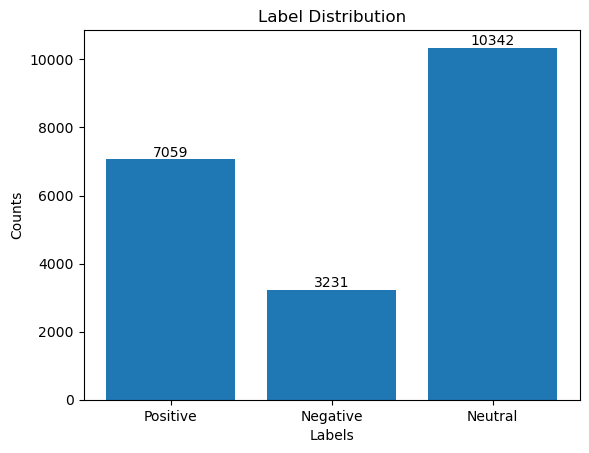

In [98]:
# Test
# Training
path_file = "../temp_data/2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"

# Read the file
with open(path_file, 'r') as file:
    lines = file.readlines()

# Initialize counters
positive_count = 0
negative_count = 0
neutral_count = 0

# Count labels
for line in lines:
    line_elements = line.strip().split('\t')
    if len(line_elements) >= 2:
        label = line_elements[1]
        if label == 'positive':
            positive_count += 1
        elif label == 'negative':
            negative_count += 1
        elif label == 'neutral':
            neutral_count += 1

# Print the counts
print("Positive count:", positive_count)
print("Negative count:", negative_count)
print("Neutral count:", neutral_count)


# Data for the pie chart
labels = ['Positive', 'Negative', 'Neutral']
counts = [positive_count, negative_count, neutral_count]

plt.bar(labels, counts)

# Add labels to the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Add a title and labels
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')


# Add a title
plt.title('Label Distribution')

# Display the chart
plt.show()

